In [1]:
# 1. Import packages
import os,keras,cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import layers,losses,callbacks,activations,regularizers,metrics,applications,optimizers

In [ ]:
# 2. Data loading and split into val and test

# current working directory
current_dir = os.getcwd()

# dataset path
dataset_path = os.path.join(current_dir, "Concrete Crack Images for Classification")
# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Load dataset with train-validation split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% of images for validation
    subset="training",
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Now split validation into val & test
nBatches = validation_dataset.cardinality().numpy()
print("Total Validation Batches:", nBatches)

val_dataset = validation_dataset.take(nBatches // 2)
test_dataset = validation_dataset.skip(nBatches // 2)

# Check dataset sizes
print("Validation Dataset Batches:", val_dataset.cardinality().numpy())
print("Test Dataset Batches:", test_dataset.cardinality().numpy())

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.
Total Validation Batches: 250
Validation Dataset Batches: 125
Test Dataset Batches: 125


Class Names: ['Negative', 'Positive']


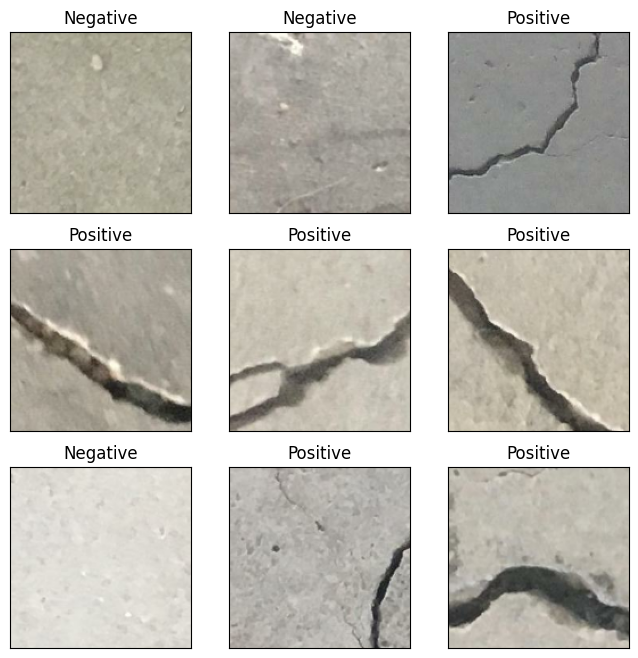

In [9]:
# 3. Inspect some data samples from the dataset
# Get class names
class_names = train_dataset.class_names
print("Class Names:", class_names)

# Take one batch from the dataset
batch_1 = train_dataset.take(1)

# Plot images
plt.figure(figsize=(8, 8))
for feature, label in batch_1:
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow(feature[i].numpy().astype('uint8'))
        plt.title(class_names[label[i].numpy()])  # Fix: Convert label to numpy
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
plt.show()


In [11]:
# 5. Convert the val and test dataset back to PrefetchDataset
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# 6. Create a sequential model for augmentation
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip())
data_augmentation.add(layers.RandomRotation(factor=0.2))

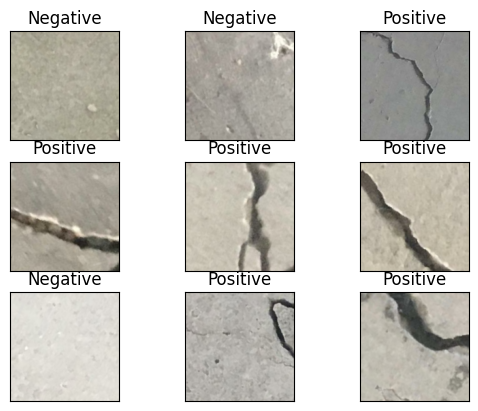

In [13]:
feature_augmented = data_augmentation(feature)
for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature_augmented[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
plt.show()

In [16]:
# Create the preprocessing layer based on the pretrained model that we will use
preprocess_input = applications.mobilenet_v2.preprocess_input

In [17]:
# 7. Apply transfer learning
# (A) Load in the pretrained model as feature extractor
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")
# Freeze the entire feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
# (B) Construct the classifier
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names),activation='softmax')

In [19]:
# (C) Use functional API to connect all the layers together
# a. Begin with the input
inputs = keras.Input(shape=IMG_SHAPE)
# b. Augmentation layers
x = data_augmentation(inputs)
# c. preprocessing layer
x = preprocess_input(x)
# d. Feature extractor
x = base_model(x)
# e. Classifier
x = global_avg(x)
outputs = output_layer(x)
# f. Create the model
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()
keras.utils.plot_model(model)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [20]:
# 8. Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [21]:
# 9. Train the model
logpath = os.path.join("transfer_learning_log",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logpath)
tb = callbacks.TensorBoard(log_dir=logpath)
es = callbacks.EarlyStopping(patience=3,verbose=1)

transfer_learning_log\20250312-100909


In [22]:
# Evaluate the model before training
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.6114 - loss: 0.6855


[0.6896052956581116, 0.6082500219345093]

In [23]:
# Proceed with the training
EPOCHS = 10
history_first = model.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[tb,es])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 179s 176ms/step - accuracy: 0.9560 - loss: 0.1372 - val_accuracy: 0.9970 - val_loss: 0.0126
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 158s 158ms/step - accuracy: 0.9972 - loss: 0.0116 - val_accuracy: 0.9975 - val_loss: 0.0079
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 157s 157ms/step - accuracy: 0.9976 - loss: 0.0090 - val_accuracy: 0.9980 - val_loss: 0.0063
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 164s 164ms/step - accuracy: 0.9975 - loss: 0.0075 - val_accuracy: 0.9983 - val_loss: 0.0055
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 170s 170ms/step - accuracy: 0.9978 - loss: 0.0064 - val_accuracy: 0.9983 - val_loss: 0.0056
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 165s 165ms/step - accuracy: 0.9984 - loss: 0.0057 - val_accuracy: 0.9980 - val_loss: 0.0056
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 166s 166ms/step - accuracy: 0.9982 - loss: 0.0056 - val_accuracy: 0.9985 - val_loss: 0.0046
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 166s 166ms/step - ac

In [24]:
# Evaluate the model after the first stage training
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9989 - loss: 0.0034


[0.004076093900948763, 0.9987499713897705]

In [25]:
# 10. 2nd stage transfer learning
# (A) Unfreeze the base model
base_model.trainable = True
# (B) Free the earlier layers of the base model
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [26]:
# Recompile the model and train again
rmsprop = optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=rmsprop,loss=loss,metrics=['accuracy'])

In [27]:
history_first.epoch[-1]

9

In [ ]:
# Run the second stage training
second_epochs = 10
total_epochs = EPOCHS + second_epochs
starting_epoch = history_first.epoch[-1] + 1
history_second = model.fit(train_dataset,validation_data=val_dataset,epochs=total_epochs,initial_epoch=starting_epoch,callbacks=[tb])

Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 256s 250ms/step - accuracy: 0.9676 - loss: 0.0809 - val_accuracy: 0.9960 - val_loss: 0.0094
Epoch 12/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 249s 249ms/step - accuracy: 0.9956 - loss: 0.0136 - val_accuracy: 0.9985 - val_loss: 0.0041
Epoch 13/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 248s 248ms/step - accuracy: 0.9972 - loss: 0.0083 - val_accuracy: 0.9985 - val_loss: 0.0039
Epoch 14/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 245s 245ms/step - accuracy: 0.9970 - loss: 0.0092 - val_accuracy: 0.9983 - val_loss: 0.0040
Epoch 15/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 242s 242ms/step - accuracy: 0.9985 - loss: 0.0052 - val_accuracy: 0.9985 - val_loss: 0.0056
Epoch 16/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 243s 243ms/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9987 - val_loss: 0.0027
Epoch 17/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 244s 244ms/step - accuracy: 0.9981 - loss: 0.0060 - val_accuracy: 0.9987 - val_loss: 0.0022
Epoch 18/20
 122/1000 ━━━━━━━━━━━━━━━━━━━━ 3:28 238ms/s

In [ ]:
# Evaluate the model after the second stage of transfer learning
model.evaluate(test_dataset)

In [ ]:
# Use the model to make prediction
for image_batch,label_batch in test_dataset.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i+9].numpy().astype('uint8'))
    plt.title(f"Prediction: {predicted_class[i+9]}, Label: {class_names[label_batch[i+9]]}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [ ]:
# Use the model to predict with a random image
img = cv2.imread(filename="cat_sample.jpg")
img = cv2.cvtColor(img,code=cv2.COLOR_BGR2RGB)
img = cv2.resize(img,dsize=(160,160))
plt.imshow(img)
plt.show()
print(img.shape)
img = np.expand_dims(img,axis=0)
print(img.shape)

In [ ]:
prediction = model.predict(img)
class_names[np.argmax(prediction,axis=1)[0]]